Input CSV exists? True -> C:\Users\arpit\Documents\CareerFoundry\outputs\Exercise_1_6\country_relationships.csv
Outputs directory: C:\Users\arpit\Documents\CareerFoundry\outputs\Exercise_1_7


,country1,country2,weight
0,France,Germany,5
1,France,United Kingdom,4
2,Japan,United States,4
3,Germany,United Kingdom,3
4,China,North Korea,3


Edges: 81  |  Nodes (approx): 41
Graph has 41 nodes and 81 edges
Density: 0.09878048780487805
Connected components: 6


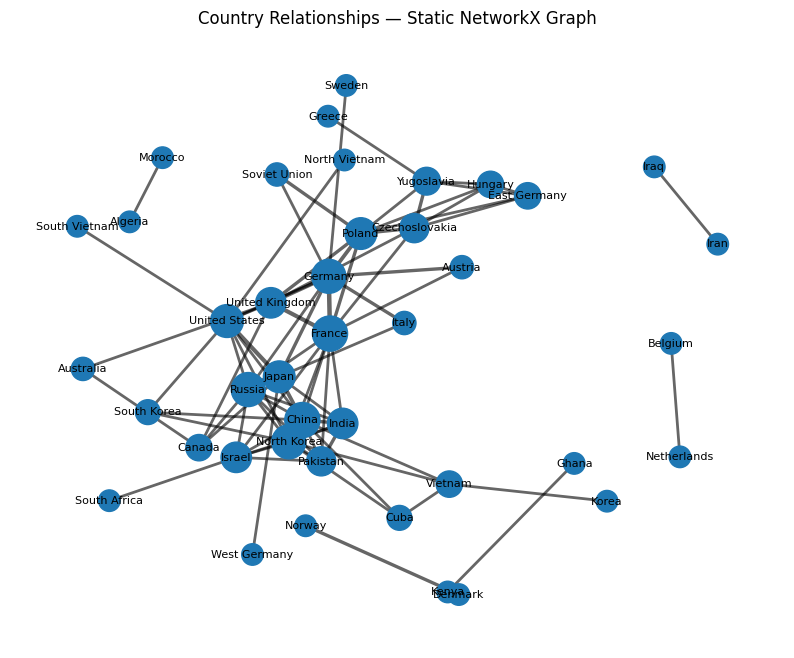

Saved: C:\Users\arpit\Documents\CareerFoundry\outputs\Exercise_1_7\network_static.png
C:\Users\arpit\Documents\CareerFoundry\outputs\Exercise_1_7\network_interactive_base.html
PyVis failed ('NoneType' object has no attribute 'render'); writing fallback HTML with vis-network CDN.
Saved interactive base graph (fallback): C:\Users\arpit\Documents\CareerFoundry\outputs\Exercise_1_7\network_interactive_base.html
Community detection: Leiden (communities=8)
C:\Users\arpit\Documents\CareerFoundry\outputs\Exercise_1_7\network_interactive_communities.html
PyVis community view failed ('NoneType' object has no attribute 'render'); writing fallback HTML with vis-network CDN.
Saved community-colored interactive graph (fallback): C:\Users\arpit\Documents\CareerFoundry\outputs\Exercise_1_7\network_interactive_communities.html
Community algorithm used: Leiden (communities=8)


,country,score
0,France,0.275
1,China,0.275
2,Russia,0.250
3,Germany,0.250
4,North Korea,0.250
5,United States,0.225
6,Japan,0.200
7,Poland,0.200
8,India,0.175
9,Israel,0.175


,country,score
0,France,0.416667
1,Germany,0.401786
2,Russia,0.401786
3,China,0.394737
4,United States,0.387931
5,United Kingdom,0.375000
6,Japan,0.375000
7,North Korea,0.375000
8,Poland,0.368852
9,India,0.351562


,country,score
0,France,0.130362
1,United States,0.115345
2,Czechoslovakia,0.105769
3,Russia,0.080812
4,North Korea,0.079800
5,Germany,0.075189
6,United Kingdom,0.069872
7,Japan,0.063722
8,China,0.055684
9,India,0.052702


Saved centrality CSVs.


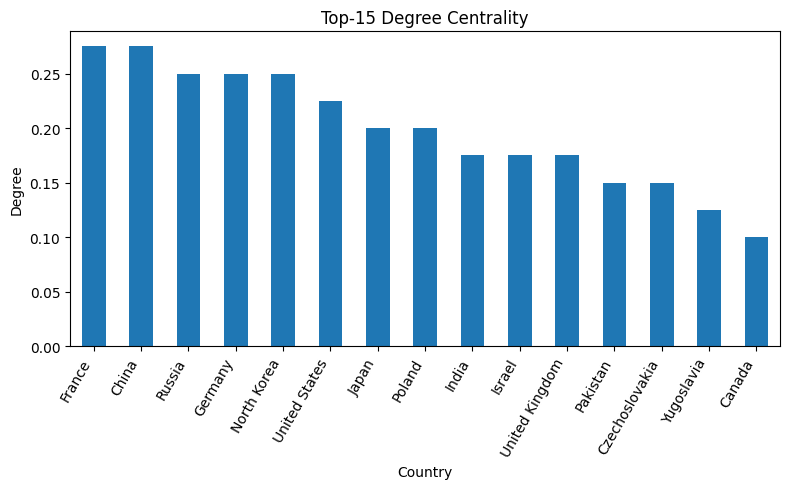

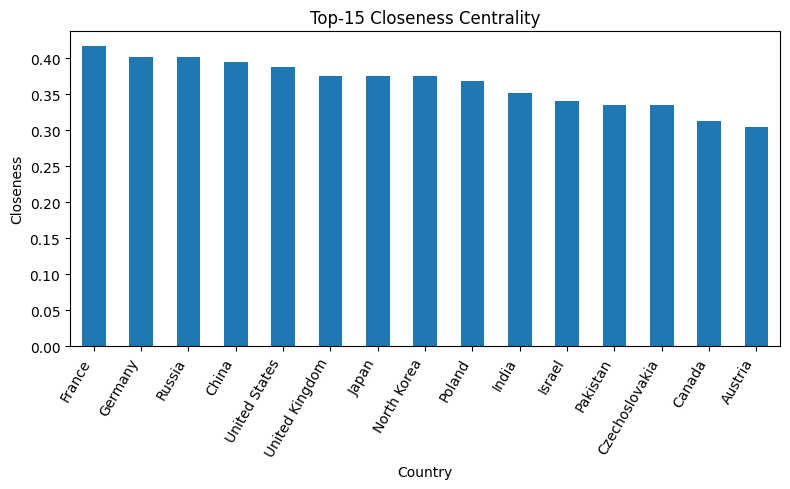

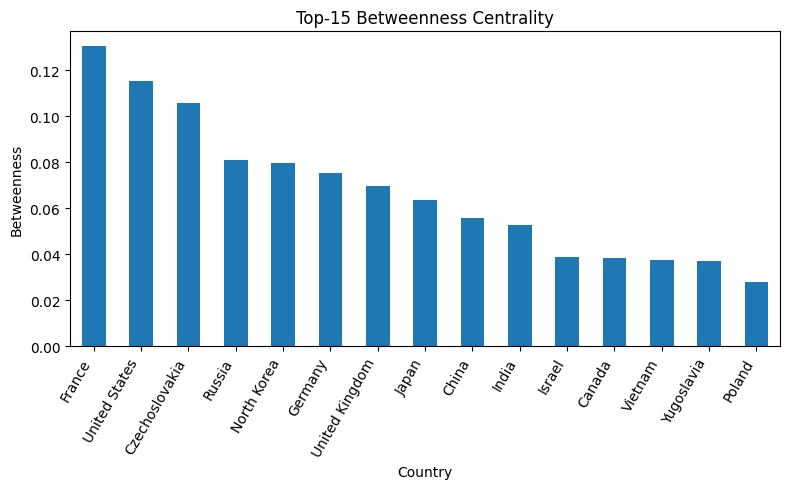

In [9]:
import os, json
from pathlib import Path
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

use_leiden = True
try:
    import igraph as ig
    import leidenalg as la
except Exception:
    use_leiden = False
    try:
        import community as community_louvain  # python-louvain
    except Exception:
        community_louvain = None

try:
    from pyvis.network import Network
    has_pyvis = True
except Exception:
    has_pyvis = False
    Network = None

PROJECT_ROOT = Path(".").resolve()
IN_CSV = PROJECT_ROOT / "outputs" / "Exercise_1_6" / "country_relationships.csv"
OUT_DIR = PROJECT_ROOT / "outputs" / "Exercise_1_7"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Input CSV exists? {IN_CSV.exists()} -> {IN_CSV}")
print(f"Outputs directory: {OUT_DIR}")

if not IN_CSV.exists():
    raise FileNotFoundError("Missing 'outputs/Exercise_1_6/country_relationships.csv' from Exercise 1.6.")

df_rel = pd.read_csv(IN_CSV)
expected_cols = {"country1","country2","weight"}
if not expected_cols.issubset(df_rel.columns):
    raise ValueError(f"Input must have {expected_cols}, found {list(df_rel.columns)}")

display(df_rel.head())
print(f"Edges: {len(df_rel)}  |  Nodes (approx): {len(set(df_rel['country1']).union(df_rel['country2']))}")

G = nx.Graph()
for _, row in df_rel.iterrows():
    u, v, w = row["country1"], row["country2"], float(row["weight"])
    if G.has_edge(u, v):
        G[u][v]["weight"] += w
    else:
        G.add_edge(u, v, weight=w)

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
print("Density:", nx.density(G))
print("Connected components:", nx.number_connected_components(G))

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42, k=0.7)

deg = dict(G.degree())
node_sizes = [200 + 40*deg[n] for n in G.nodes()]
edge_widths = [1 + (d.get("weight", 1.0) ** 0.5) for _, _, d in G.edges(data=True)]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.axis("off")
plt.title("Country Relationships — Static NetworkX Graph")
static_path = OUT_DIR / "network_static.png"
plt.savefig(static_path, bbox_inches="tight", dpi=150)
plt.show()
print(f"Saved: {static_path}")

def write_vis_network_html(nodes, edges, out_path, title="Interactive Network"):
    """
    Minimal vis-network HTML writer (no PyVis). Nodes: list of dict(id,label,value,title,color?)
    Edges: list of dict(from,to,value,title)
    """
    # CDN resources (no local files needed)
    html = f"""<!doctype html>
<html>
<head>
  <meta charset="utf-8"/>
  <title>{title}</title>
  <script type="text/javascript" src="https://unpkg.com/vis-network/standalone/umd/vis-network.min.js"></script>
  <style>#mynetwork {{ width: 100%; height: 750px; border: 1px solid #ddd; }}</style>
</head>
<body>
<h3 style="font-family: sans-serif;">{title}</h3>
<div id="mynetwork"></div>
<script type="text/javascript">
  const nodes = new vis.DataSet({json.dumps(nodes, ensure_ascii=False)});
  const edges = new vis.DataSet({json.dumps(edges, ensure_ascii=False)});
  const container = document.getElementById('mynetwork');
  const data = {{ nodes: nodes, edges: edges }};
  const options = {{
    physics: {{
      enabled: true,
      barnesHut: {{ gravitationalConstant: -2000, springLength: 120, damping: 0.4 }}
    }},
    nodes: {{ shape: 'dot', scaling: {{ min: 5, max: 50 }} }},
    edges: {{ scaling: {{ min: 1, max: 8 }}, smooth: true }},
    interaction: {{ hover: true, tooltipDelay: 120 }}
  }};
  const network = new vis.Network(container, data, options);
</script>
</body>
</html>"""
    Path(out_path).write_text(html, encoding="utf-8")
    return out_path


node_dicts = []
for n in G.nodes():
    node_dicts.append({
        "id": n, "label": n, "value": deg[n],
        "title": f"{n} — degree {deg[n]}"
    })
edge_dicts = []
for u, v, d in G.edges(data=True):
    w = float(d.get("weight", 1.0))
    edge_dicts.append({
        "from": u, "to": v, "value": w,
        "title": f"weight={w}"
    })

html_base = OUT_DIR / "network_interactive_base.html"

def make_pyvis_html(path, nodes, edges):
    net = Network(height="750px", width="100%", bgcolor="#ffffff", notebook=False, directed=False)
    net.barnes_hut()
    for nd in nodes:
        net.add_node(nd["id"], label=nd["label"], value=nd["value"], title=nd["title"])
    for ed in edges:
        net.add_edge(ed["from"], ed["to"], value=ed["value"], title=ed["title"])
    # The next line sometimes fails on Windows due to missing template packaging
    net.show(str(path))  # writes HTML and prints path

try:
    if has_pyvis:
        make_pyvis_html(html_base, node_dicts, edge_dicts)
        print(f"Saved interactive base graph (PyVis): {html_base}")
    else:
        raise RuntimeError("PyVis not available")
except Exception as e:
    print(f"PyVis failed ({e}); writing fallback HTML with vis-network CDN.")
    write_vis_network_html(node_dicts, edge_dicts, html_base, title="Country Relationships — Interactive (fallback)")
    print(f"Saved interactive base graph (fallback): {html_base}")


communities = {}
algo_used = None

if use_leiden:
    ig_graph = ig.Graph()
    ig_graph.add_vertices(list(G.nodes()))
    ig_graph.add_edges(list(G.edges()))
    weights = [float(G[u][v].get("weight", 1.0)) for u, v in G.edges()]
    ig_graph.es["weight"] = weights

    part = la.find_partition(ig_graph, la.RBConfigurationVertexPartition, weights=ig_graph.es["weight"])
    for comm_id, nodes in enumerate(part):
        for node_index in nodes:
            node_name = ig_graph.vs[node_index]["name"]
            communities[node_name] = comm_id
    algo_used = f"Leiden (communities={len(part)})"

elif 'community_louvain' in globals() and community_louvain is not None:
    best_part = community_louvain.best_partition(G, weight="weight", random_state=42)
    communities = best_part
    algo_used = f"Louvain (communities={len(set(best_part.values()))})"

else:
    algo_used = "None — install igraph+leidenalg or python-louvain"
    print("WARNING: No community detection lib found. Skipping communities.")

print("Community detection:", algo_used)
list(communities.items())[:10]


def community_color(cid: int):
    palette = [
        "#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd",
        "#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf"
    ]
    return palette[cid % len(palette)]

# Build colored nodes for community view
node_dicts_comm = []
for n in G.nodes():
    nd = {
        "id": n, "label": n, "value": deg[n],
        "title": f"{n} — degree {deg[n]}"
    }
    if n in communities:
        cid = communities[n]
        nd["title"] += f" | community {cid}"
        nd["color"] = community_color(cid)
    node_dicts_comm.append(nd)

html_comm = OUT_DIR / "network_interactive_communities.html"

def make_pyvis_html_comm(path, nodes, edges):
    net = Network(height="750px", width="100%", bgcolor="#ffffff", notebook=False, directed=False)
    net.barnes_hut()
    for nd in nodes:
        net.add_node(nd["id"], label=nd["label"], value=nd["value"], title=nd["title"], color=nd.get("color"))
    for ed in edges:
        net.add_edge(ed["from"], ed["to"], value=ed["value"], title=ed["title"])
    net.show(str(path))

try:
    if has_pyvis and communities:
        make_pyvis_html_comm(html_comm, node_dicts_comm, edge_dicts)
        print(f"Saved community-colored interactive graph (PyVis): {html_comm}")
    else:
        raise RuntimeError("PyVis not available or no communities computed")
except Exception as e:
    print(f"PyVis community view failed ({e}); writing fallback HTML with vis-network CDN.")
    write_vis_network_html(node_dicts_comm, edge_dicts, html_comm,
                           title=f"Communities — Interactive (fallback) | {algo_used}")
    print(f"Saved community-colored interactive graph (fallback): {html_comm}")
    print(f"Community algorithm used: {algo_used}")

# %%
deg_c = nx.degree_centrality(G)
clo_c = nx.closeness_centrality(G)                 # unweighted closeness
bet_c = nx.betweenness_centrality(G, weight='weight', normalized=True)

def top_series(d: dict, k=15):
    s = pd.Series(d, name="score").sort_values(ascending=False)
    return s.head(k)

top_deg = top_series(deg_c)
top_clo = top_series(clo_c)
top_bet = top_series(bet_c)

display(pd.DataFrame(top_deg).rename_axis("country").reset_index())
display(pd.DataFrame(top_clo).rename_axis("country").reset_index())
display(pd.DataFrame(top_bet).rename_axis("country").reset_index())

# Save CSVs
(top_deg.to_frame().to_csv(OUT_DIR / "centrality_degree.csv"))
(top_clo.to_frame().to_csv(OUT_DIR / "centrality_closeness.csv"))
(top_bet.to_frame().to_csv(OUT_DIR / "centrality_betweenness.csv"))
print("Saved centrality CSVs.")

# ### Plot Top-15 Centralities

plt.figure(figsize=(8,5))
top_deg.plot(kind='bar')
plt.title("Top-15 Degree Centrality")
plt.ylabel("Degree")
plt.xlabel("Country")
plt.xticks(rotation=60, ha='right')
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
top_clo.plot(kind='bar')
plt.title("Top-15 Closeness Centrality")
plt.ylabel("Closeness")
plt.xlabel("Country")
plt.xticks(rotation=60, ha='right')
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
top_bet.plot(kind='bar')
plt.title("Top-15 Betweenness Centrality")
plt.ylabel("Betweenness")
plt.xlabel("Country")
plt.xticks(rotation=60, ha='right')
plt.tight_layout(); plt.show()
